# Pre-processing of the outputevents dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
file_path = 'C:/Users/Jacob/Documents/datasets/mimic-iv-0.4/'
save_path = 'C:/Users/Jacob/Documents/datasets/mimic-iv-0.4-processed/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [4]:
adm = pd.read_csv(os.path.join(save_path, "icu", "admissions.csv"))
out = pd.read_csv(os.path.join(file_path, "icu", "outputevents.csv"))

In [5]:
# Restrict the dataset to the previously selected admission ids only.
out = out.loc[out["hadm_id"].isin(adm["hadm_id"])]

print("Number of patients remaining in the database: ")
print(out["subject_id"].nunique())

Number of patients remaining in the database: 
10729


In [6]:
# item_id
item_id = pd.read_csv(os.path.join(file_path, "icu", "d_items.csv"), usecols=["itemid", "label"])

#We merge the name of the item administrated.
out = pd.merge(out, item_id, on="itemid")
out.head()

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valueuom,label
0,10004720,22081550,30274385,2186-11-12 20:00:00,2186-11-12 20:55:00,226559,350.0,ml,Foley
1,10004720,22081550,30274385,2186-11-12 21:00:00,2186-11-12 20:56:00,226559,65.0,ml,Foley
2,10004720,22081550,30274385,2186-11-12 22:00:00,2186-11-12 22:11:00,226559,40.0,ml,Foley
3,10004720,22081550,30274385,2186-11-12 23:00:00,2186-11-12 23:12:00,226559,13.0,ml,Foley
4,10004720,22081550,30274385,2186-11-13 00:00:00,2186-11-13 00:12:00,226559,10.0,ml,Foley


In [7]:
n_best = 20
# For each item, evaluate the number of patients who have been given this item.
pat_for_item = out.groupby("label")["subject_id"].nunique()
# Order by occurence and take the 20 best (the ones with the most patients)
frequent_labels = pat_for_item.sort_values(ascending=False)[:n_best]

# Select only the time series with high occurence.
out = out.loc[out["label"].isin(list(frequent_labels.index))]

print(frequent_labels)
print("Number of patients remaining in the database: ")
print(out["subject_id"].nunique())
print("Number of datapoints remaining in the database: ")
print(len(out))

label
Foley                 9023
Void                  4395
OR Urine              3363
Chest Tube #1         2618
Oral Gastric          1844
Pre-Admission         1723
OR EBL                1558
TF Residual           1519
Emesis                 860
Nasogastric            762
Stool                  680
Jackson Pratt #1       588
TF Residual Output     497
Fecal Bag              495
Straight Cath          384
Condom Cath            368
Chest Tube #2          321
Gastric Tube           287
Rectal Tube            275
PACU Urine             260
Name: subject_id, dtype: int64
Number of patients remaining in the database: 
10717
Number of datapoints remaining in the database: 
695371


## Cleaning of the output data

### Units Cleaning

#### 1) Amounts

In [8]:
# Verification that all input labels have the same amounts units.
out.groupby("label")["valueuom"].value_counts(dropna=False)

label               valueuom
Chest Tube #1       ml           59883
Chest Tube #2       ml            7647
Condom Cath         ml            4493
Emesis              ml            1562
Fecal Bag           ml            2087
Foley               ml          532716
Gastric Tube        ml             880
Jackson Pratt #1    ml            6265
Nasogastric         ml            3622
OR EBL              ml            1868
OR Urine            ml            3853
Oral Gastric        ml            5297
PACU Urine          ml             287
Pre-Admission       ml            2156
Rectal Tube         ml             869
Stool               ml            1840
Straight Cath       ml            1377
TF Residual         ml           15064
TF Residual Output  ml            1598
Void                ml           42007
Name: valueuom, dtype: int64

### Check for outliers

#### 1) In amounts

In [9]:
out.groupby("label")["value"].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Chest Tube #1,59883.0,35.935908,65.492126,0.0,10.0,25.0,45.00,2700.0
Chest Tube #2,7647.0,31.374918,60.622361,0.0,0.0,20.0,40.00,1300.0
Condom Cath,4493.0,250.060316,212.567216,0.0,100.0,200.0,325.00,2300.0
Emesis,1562.0,147.850832,183.346750,0.0,50.0,100.0,200.00,3150.0
Fecal Bag,2087.0,446.246287,328.140604,0.0,200.0,400.0,700.00,3000.0
Foley,532716.0,125.787673,140.249325,0.0,45.0,85.0,150.00,25025.0
Gastric Tube,880.0,159.411364,174.933952,0.0,50.0,100.0,200.00,1550.0
Jackson Pratt #1,6265.0,67.877686,96.377581,0.0,20.0,40.0,80.00,1100.0
Nasogastric,3622.0,196.334898,328.310551,0.0,50.0,150.0,250.00,15000.0


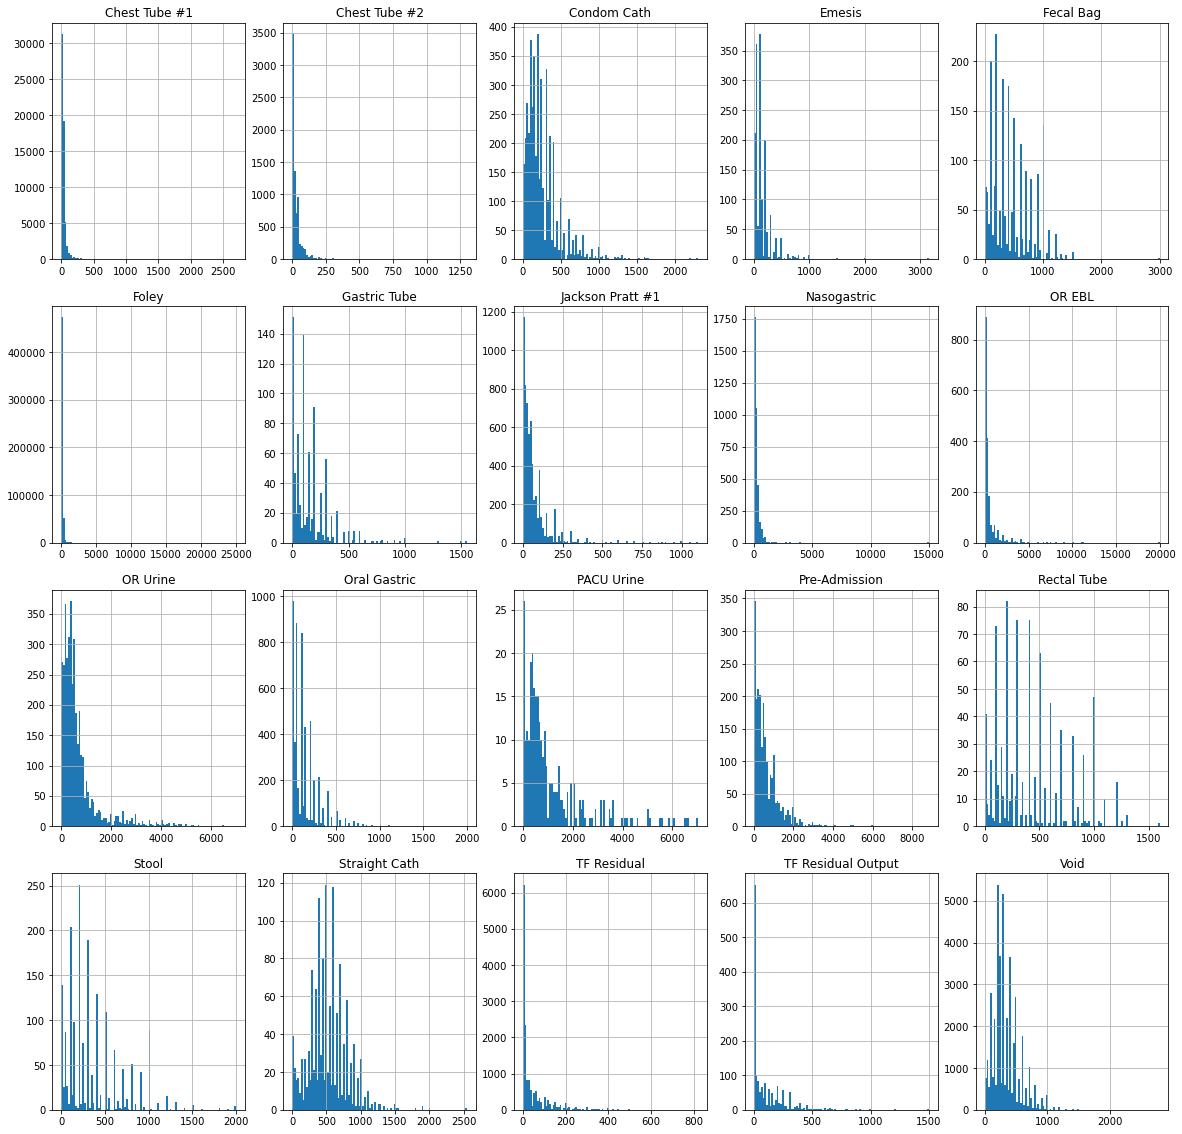

In [10]:
plt.figure(figsize=(20, 20))
for i, label in enumerate(sorted(out["label"].unique())):
    plt.subplot(4, 5, 1+i)
    out["value"][out["label"] == label].hist(bins=100)
    plt.title(label)

In [11]:
# Chest Tube #1 - remove values over 500
out = out.drop(out.loc[(out["label"] == "Chest Tube #1") & (out["value"] > 500)].index)

# Chest Tube #2 - remove values over 500
out = out.drop(out.loc[(out["label"] == "Chest Tube #2") & (out["value"] > 500)].index)

# Condom Cath - remove values over 1500
out = out.drop(out.loc[(out["label"] == "Condom cath") & (out["value"] > 1500)].index)

# Emesis - remove values over 1000
out = out.drop(out.loc[(out["label"] == "Emesis") & (out["value"] > 1000)].index)

# Fecal Bag - remove values over 1500
out = out.drop(out.loc[(out["label"] == "Fecal Bag") & (out["value"] > 1500)].index)

# Foley - remove values over 5500
out = out.drop(out.loc[(out["label"] == "Foley") & (out["value"] > 5500)].index)

# Gastric Tube - remove values over 1000
out = out.drop(out.loc[(out["label"] == "Gastric Tube") & (out["value"] > 1000)].index)

# Jackson Pratt #1 - remove values over 500
out = out.drop(out.loc[(out["label"] == "Jackson Pratt #1") & (out["value"] > 500)].index)

# Nasogastric - remove values over 2500
out = out.drop(out.loc[(out["label"] == "Nasogastric") & (out["value"] > 2500)].index)

# OR EBL - remove values over 5000
out = out.drop(out.loc[(out["label"] == "OR EBL") & (out["value"] > 5000)].index)

# OR Urine - remove values over 6000
out = out.drop(out.loc[(out["label"] == "OR Urine") & (out["value"] > 6000)].index)

# Oral Gastric - remove values over 1000
out = out.drop(out.loc[(out["label"] == "Oral Gastric") & (out["value"] > 1000)].index)

# PACU Urine - remove values over 4000
out = out.drop(out.loc[(out["label"] == "PACU Urine") & (out["value"] > 4000)].index)

# Pre-Admission - remove values over 4000
out = out.drop(out.loc[(out["label"] == "Pre-Admission") & (out["value"] > 4000)].index)

# Rectal Tube - remove values over 1500
out = out.drop(out.loc[(out["label"] == "Rectal Tube") & (out["value"] > 1500)].index)

# Stool - remove values over 1500 (and below 0)
out = out.drop(out.loc[(out["label"] == "Stool") & ((out["value"] > 1500) | (out["value"] < 0))].index)

# Straight Cath - remove values over 1500
out = out.drop(out.loc[(out["label"] == "Straight Cath") & (out["value"] > 1500)].index)

# TF Residual - remove values over 500
out = out.drop(out.loc[(out["label"] == "TF Residual") & (out["value"] > 500)].index)

# TF Residual Output - remove values over 500
out = out.drop(out.loc[(out["label"] == "TF Residual Output") & (out["value"] > 500)].index)

# Void - remove values over 1500
out = out.drop(out.loc[(out["label"] == "Void") & (out["value"] > 1500)].index)

print("Number of patients remaining in the database: ")
print(out["subject_id"].nunique())
print("Number of datapoints remaining in the database: ")
print(len(out))

Number of patients remaining in the database: 
10715
Number of datapoints remaining in the database: 
694961


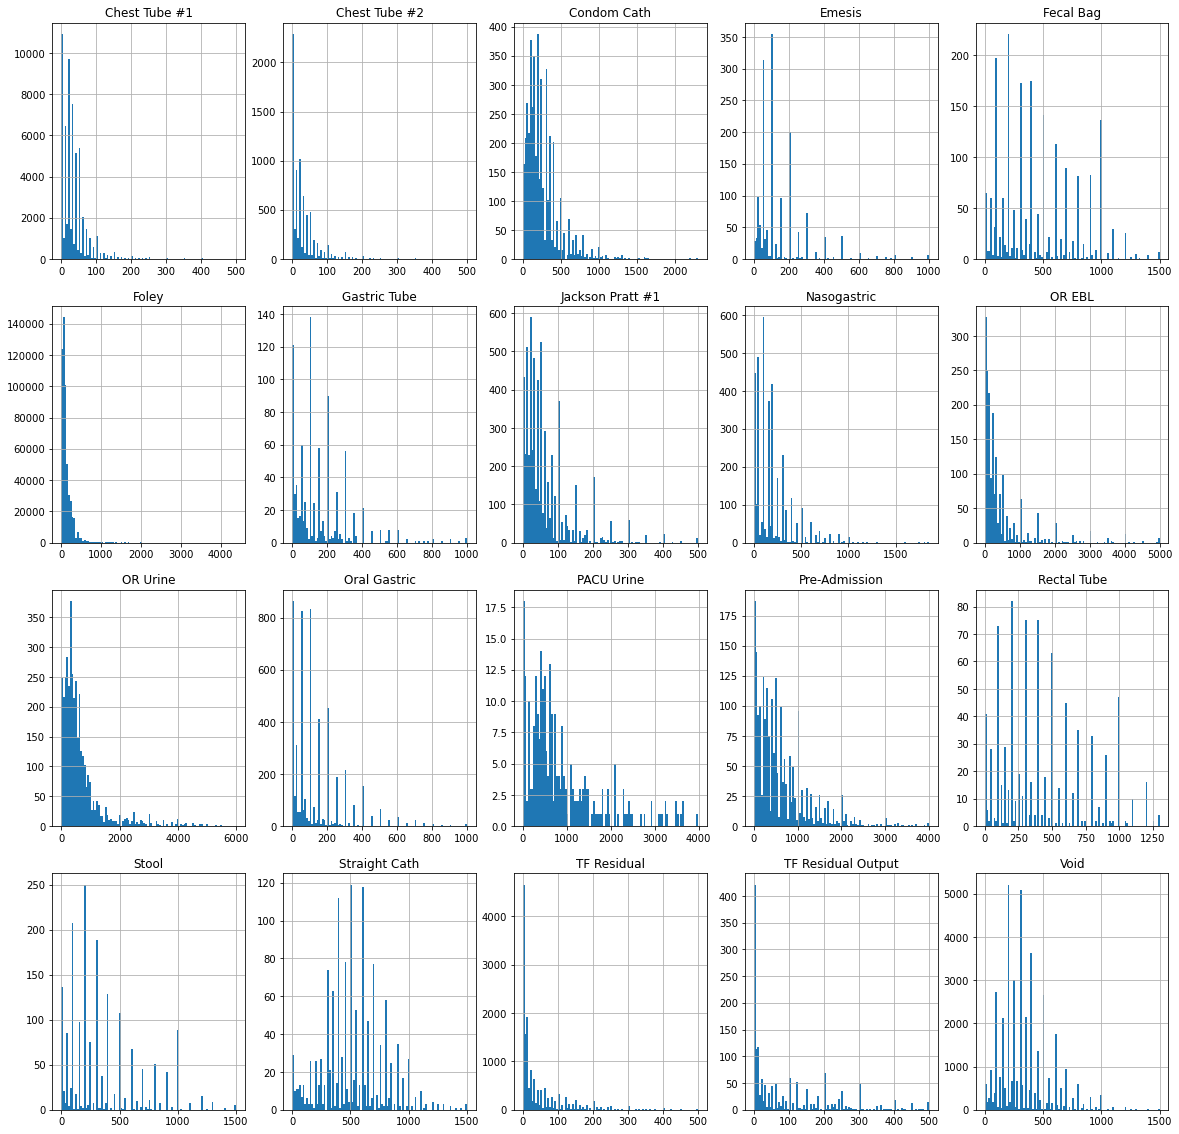

In [12]:
plt.figure(figsize=(20, 20))
for i, label in enumerate(sorted(out["label"].unique())):
    plt.subplot(4, 5, 1+i)
    out["value"][out["label"] == label].hist(bins=100)
    plt.title(label)

## GaussRank rescaling

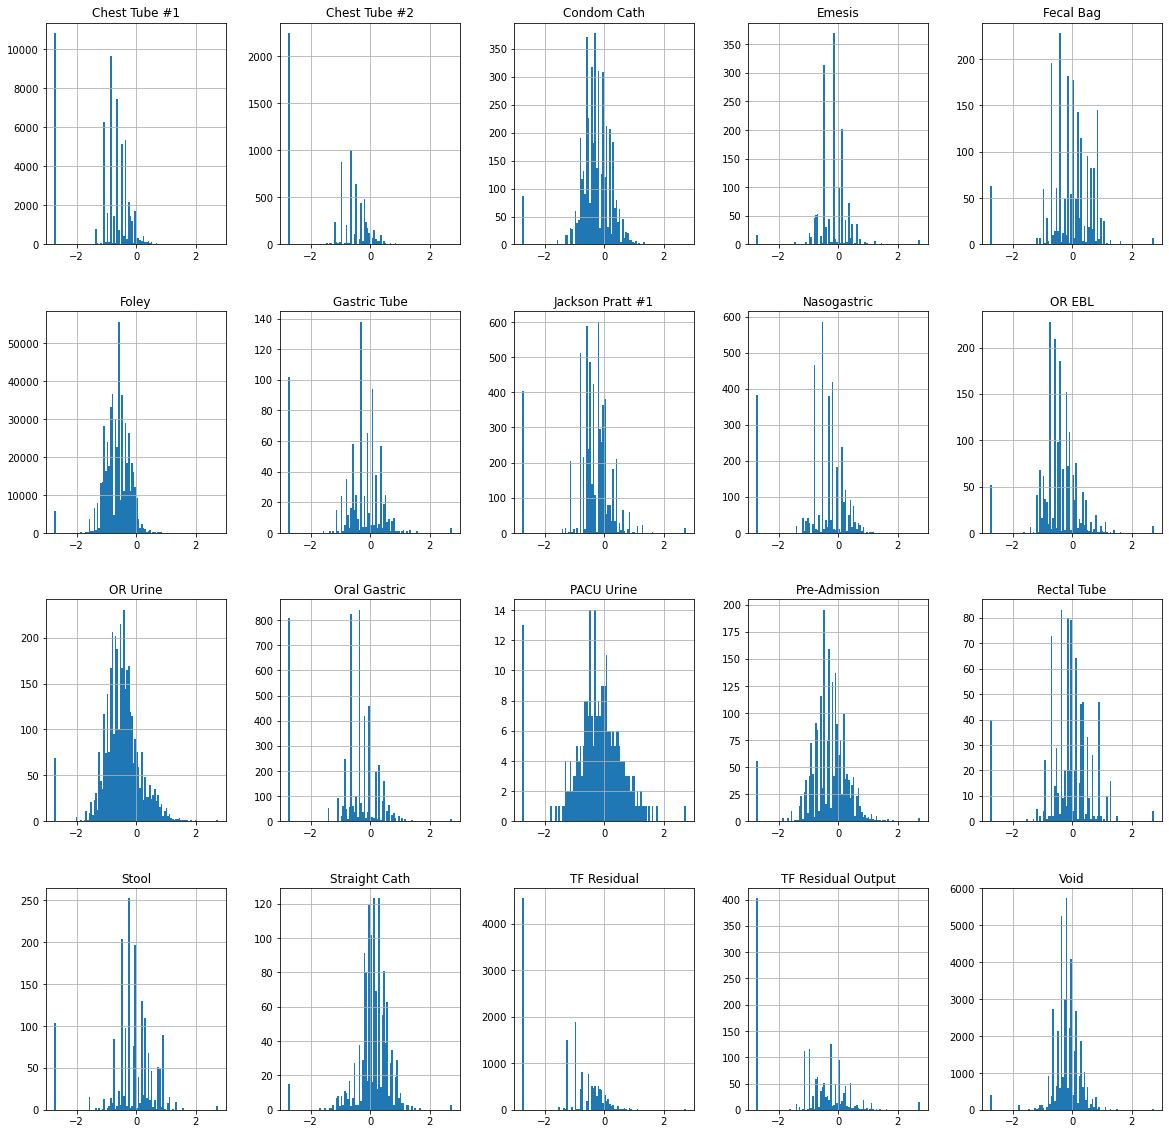

In [13]:
from gauss_rank_scaler import GaussRankScaler

fig, axes = plt.subplots(4, 5, figsize=(20, 20))
axes = [ax for sub_ax in axes for ax in sub_ax]
for i, label in enumerate(sorted(out["label"].unique())):
    scaler = GaussRankScaler()
    series = out["value"][out["label"] == label]
    X_train_new = scaler.fit_transform(series[:, np.newaxis])
    pd.DataFrame(X_train_new, columns=[label]).hist(ax=axes[i], bins=100)

In [14]:
out.to_csv(os.path.join(save_path, "icu", "outputevents.csv"))